# T-type assignment and technical figures

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

# import my feature selection and reference mapping functions 
# (adapted from The Art of Using t-SNE, but extended here)
import rnaseqTools

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.minor.width'] = .5
    matplotlib.rcParams['ytick.minor.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# Our layer definition
with np.errstate(invalid='ignore'):
    layers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    layers[normdepth < 0.07] = '1'
    layers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    layers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers[normdepth > 0.73] = '6'

## Some statistics

In [4]:
assert np.unique(m1.layers).size == 4

print('Layer                     1             2/3             5             6              ALL')
print('Morph                 all  yes       all  yes       all  yes       all  yes       all  yes')
print('------------------------------------------------------------------------------------------')
for c in ['PV+', 'SST+', 'VIP+', 'VIPR2+', 'VIAAT+', 'NPY+', 'SLC17a8+', 'SLC17a8-iCre+', 
          'GNB4+', 'WT', '-', 'ALL']:
    if c=='ALL':
        print('------------------------------------------------------------------------------------------')
    print('{:14}'.format(c), end='')
    if c=='-':
        cc = [a for a in np.unique(m1.cre) if a[-1]=='-']
    elif c=='WT':
        cc = ['SCNN1', 'WT']
    elif c=='ALL':
        cc = np.unique(m1.cre)
    else:
        cc = [c]
    if c!='-':
        print('[{:3}]  '.format(np.sum(np.isin(list(m1.mice_cres.values()), 
                            [ccc[:-1] if ccc[-1]=='+' or ccc[-1]=='-' else ccc for ccc in cc]))), end='')
    else:
        print('       ', end='')
    for l in ['1', '2/3', '5', '6']:
        print('{:4} '.format(np.sum(np.isin(m1.cre,cc) & (layers==l))), end='')
        print('{:4}      '.format(np.sum(np.isin(m1.cre,cc) & (layers==l) & m1.traced)), end='')
    print('{:4} '.format(np.sum(np.isin(m1.cre,cc))), end='')
    print('{:4}'.format(np.sum(np.isin(m1.cre,cc) & m1.traced)))

Layer                     1             2/3             5             6              ALL
Morph                 all  yes       all  yes       all  yes       all  yes       all  yes
------------------------------------------------------------------------------------------
PV+           [ 76]     0    0        65   23       117   54        29   18       211   95
SST+          [ 75]     0    0        92   42       166   59        54   25       312  126
VIP+          [ 46]     6    1        67   34        57   22        30   10       160   67
VIPR2+        [  7]     0    0        27   17         9    5         4    3        40   25
VIAAT+        [ 24]     6    3        18    6        29   16        20   12        73   37
NPY+          [  2]     1    1         2    0         2    0         4    2         9    3
SLC17a8+      [  6]     0    0         6    3        18    8        10    6        34   17
SLC17a8-iCre+ [  2]     0    0         1    1         1    1         0    0         2    2
G

In [5]:
print('EXONS')
seqdepths     = np.array(np.sum(m1.exonCounts,   axis=1))
genesdetected = np.array(np.sum(m1.exonCounts>0, axis=1))

print('Seq depths: median {:.0f}, mean+-STD log10: {:.1f}+-{:.1f}'.format(
    np.median(seqdepths), np.mean(np.log10(seqdepths)), np.std(np.log10(seqdepths))))

print('Genes detected: median {:.0f}, mean+-STD: {:.0f}+-{:.0f}'.format(
    np.median(genesdetected), np.mean(genesdetected), np.std(genesdetected)))

print('\nINTRONS')

seqdepths     = np.array(np.sum(m1.intronCounts,   axis=1))
genesdetected = np.array(np.sum(m1.intronCounts>0, axis=1))

print('Seq depths: median {:.0f}, mean+-STD log10: {:.1f}+-{:.1f}'.format(
    np.median(seqdepths), np.mean(np.log10(seqdepths)), np.std(np.log10(seqdepths))))

print('Genes detected: median {:.0f}, mean+-STD: {:.0f}+-{:.0f}'.format(
    np.median(genesdetected), np.mean(genesdetected), np.std(genesdetected)))

print('\nBOTH')

seqdepths     = np.array(np.sum(m1.intronCounts+m1.exonCounts,   axis=1))
genesdetected = np.array(np.sum(m1.intronCounts+m1.exonCounts>0, axis=1))

print('Seq depths: median {:.0f}, mean+-STD log10: {:.1f}+-{:.1f}'.format(
    np.median(seqdepths), np.mean(np.log10(seqdepths)), np.std(np.log10(seqdepths))))

print('Genes detected: median {:.0f}, mean+-STD: {:.0f}+-{:.0f}'.format(
    np.median(genesdetected), np.mean(genesdetected), np.std(genesdetected)))

EXONS
Seq depths: median 1281492, mean+-STD log10: 6.0+-0.6
Genes detected: median 6897, mean+-STD: 6766+-2742

INTRONS
Seq depths: median 687965, mean+-STD log10: 5.6+-0.8
Genes detected: median 5649, mean+-STD: 5234+-2770

BOTH
Seq depths: median 2117172, mean+-STD log10: 6.2+-0.6
Genes detected: median 9589, mean+-STD: 9097+-3533


In [6]:
print('Percentiles of mice ages: ', np.percentile(list(m1.mice_ages.values()), [0,25,50,75,100]))

Percentiles of mice ages:  [ 35.  64.  75. 100. 245.]


## Type assignment

In [3]:
def consensus_assignment(counts, genes, intronCounts=None, exonLengths=None, intronLengths=None):
    
    results = {}
    n = counts.shape[0]
    
    # Map to Tasic for QC    
    tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))
    if intronCounts is not None:
        tasicAss, tasicCorrs = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts, genes, tasic2018['clusters'], returnCmeans=True,
                newIntronCounts=intronCounts, referenceIntronCounts=tasic2018['intronCounts'],
                newExonLengths=exonLengths, newIntronLengths=intronLengths,
                normalizeNew=True, normalizeReference=True)        
    else:
        tasicAss, tasicCorrs = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts, genes, tasic2018['clusters'], returnCmeans=True)
    tasicCorrs[np.isnan(tasicCorrs)] = 0

    excl = np.amax(tasicCorrs, axis=1) < .4
    print('Excluded because max corr < .4:                   {}'.format(np.sum(excl)))
    lowq = excl
    
    excl = ~lowq & (np.amax(tasicCorrs[:,:117], axis=1) < .4)
    print('Excluded because max neural corr < .4:            {}'.format(np.sum(excl)))
    lowq |= excl
    
#     excl = ~lowq & (np.amax(tasicCorrs[:,117:], axis=1) > np.amax(tasicCorrs[:,:117], axis=1))
#     print('Excluded because non-neural corr > neural corr:   {}'.format(np.sum(excl)))
#     lowq |= excl
    
    excl = ~lowq & np.isin(np.argmax(tasicCorrs,axis=1), [115,116])
    print('Excluded because mapping to Meis2/CR:             {}'.format(np.sum(excl)))
    lowq |= excl
    
    orderBorders = [0,29,60,115]
    tasicCorrs_maxOrder = np.zeros((n, len(orderBorders)-1))
    for i in range(len(orderBorders)-1):
        tasicCorrs_maxOrder[:,i] = np.amax(tasicCorrs[:,orderBorders[i]:orderBorders[i+1]], axis=1) 
    orderDelta = np.diff(np.sort(tasicCorrs_maxOrder,axis=1)[:,-2:], axis=1).squeeze()
    excl = ~lowq & (orderDelta<0.02)
    print('Excluded because the delta between orders < 0.02: {}'.format(np.sum(excl)))
    lowq |= excl

    results['qc'] = np.array(['low quality'] * n, dtype='object')
    results['qc'][~lowq] = 'good'
    results['tasicCorrs'] = tasicCorrs
    
    tasicOrder = np.argmax(tasicCorrs_maxOrder, axis=1)
    tasicOrder[lowq] = -1
    
    # Bootstrap Tasic for good cells
    if intronCounts is not None:
        ass, ass_boot = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts[~lowq,:], genes, tasic2018['clusters'], bootstrap=True, seed=42,
                newIntronCounts=intronCounts[~lowq,:], referenceIntronCounts=tasic2018['intronCounts'],
                newExonLengths=exonLengths, newIntronLengths=intronLengths,
                normalizeNew=True, normalizeReference=True)        
    else:
        ass, ass_boot = rnaseqTools.map_to_clusters(tasic2018['counts'], tasic2018['genes'],
                counts[~lowq,:], genes, tasic2018['clusters'], bootstrap=True, seed=42)

    results['tasic_ass'] = np.zeros(n) * np.nan
    results['tasic_ass'][~lowq] = ass

    results['tasic_ass_boot'] = np.zeros((n, tasic2018['clusterNames'].size)) * np.nan
    results['tasic_ass_boot'][~lowq, :] = ass_boot

    
    # Consensus over M1 datasets
    results['m1ass'] = {}
    results['m1corrs'] = {}
    results['m1boot'] = {}

    for dataset in ['10X_cells_v2_AIBS', '10X_nuclei_v2_AIBS',
                '10X_cells_v3_AIBS', '10X_nuclei_v3_AIBS',
                'SmartSeq_cells_AIBS', 'SmartSeq_nuclei_AIBS',
                '10X_nuclei_v3_Broad']:
    
        m1data = pickle.load(open('../data/processed/reduced-allen-data/' + dataset + '.pickle', 'rb'))
        K = m1data['neurons']['clusterNames'].size
        results['m1ass'][dataset] = np.zeros(n) * np.nan
        results['m1corrs'][dataset] = np.zeros((n, K)) * np.nan
        results['m1boot'][dataset] = np.zeros((n, K)) * np.nan
    
        for order, referenceKey in enumerate(['viplamp', 'pvsst', 'exc']):
            subset = (tasicOrder == order)

            if intronCounts is not None:
                ass, ass_boot, Cmeans = rnaseqTools.map_to_clusters(
                m1data[referenceKey]['counts'], m1data[referenceKey]['genes'],
                counts[subset,:], genes, m1data[referenceKey]['clusters'], 
                bootstrap=True, returnCmeans=True, seed=42, totalClusters=K,
                newIntronCounts=intronCounts[subset,:], 
                referenceIntronCounts=m1data[referenceKey]['intronCounts'] if 'SmartSeq' in dataset else None,
                newExonLengths=exonLengths, newIntronLengths=intronLengths,
                normalizeNew=True, normalizeReference='SmartSeq' in dataset)
                
            else:
                ass, ass_boot, Cmeans = rnaseqTools.map_to_clusters(
                m1data[referenceKey]['counts'], m1data[referenceKey]['genes'],
                counts[subset,:], genes, m1data[referenceKey]['clusters'], 
                bootstrap=True, returnCmeans=True, seed=42, totalClusters=K)
        
            results['m1ass'][dataset][subset] = ass
            results['m1corrs'][dataset][subset,:] = Cmeans
            results['m1boot'][dataset][subset,:] = ass_boot
        
    results['m1consensus_boot'] = np.zeros((n, K))
    for dataset in results['m1boot']:
        results['m1consensus_boot'] += results['m1boot'][dataset]
    results['m1consensus_boot'] /= len(results['m1boot'])

    results['m1consensus_ass'] = np.zeros(n) * np.nan
    mapped = np.sum(~np.isnan(results['m1consensus_boot']), axis=1) > 0
    results['m1consensus_ass'][mapped] = np.argmax(results['m1consensus_boot'][mapped,:], axis=1)
    
    # Final type and family
    results['type'] = np.array([''] * n, dtype='object')
    results['type'][~lowq] = clusterNames[results['m1consensus_ass'][~lowq].astype(int)]

    results['family'] = np.array(['low quality'] * n, dtype='object')
    families = ['Lamp5']*8 + ['Sncg']*5 + ['Vip']*14 + ['Sst']*20 + ['Pvalb']*10 + \
               ['IT']*12 + ['ET']*4 + ['NP']*4 + ['CT']*11
    results['family'][~lowq] = [families[i] for i in results['m1consensus_ass'][~lowq].astype(int)]
    
    results['confidence'] = np.zeros(n) * np.nan
    results['confidence'][~lowq] = np.max(results['m1consensus_boot'][mapped,:], axis=1)
    
    return results

In [5]:
%%time

ttypes = consensus_assignment(m1.exonCounts, m1.genes, intronCounts=m1.intronCounts,
                              exonLengths=m1.exonLengths, intronLengths=m1.intronLengths)

pickle.dump(ttypes, open('../data/processed/rnaseq/ttypes.pickle', 'wb'))

Using a common set of 2666 genes.
Excluded because max corr < .4:                   78
Excluded because max neural corr < .4:            14
Excluded because mapping to Meis2/CR:             0
Excluded because the delta between orders < 0.02: 5
Using a common set of 2666 genes.
.................................................................................................... done
Using a common set of 490 genes.
.................................................................................................... done
Using a common set of 493 genes.
.................................................................................................... done
Using a common set of 478 genes.
.................................................................................................... done
Using a common set of 483 genes.
.................................................................................................... done
Using a common set of 484 genes.
...........................

In [3]:
# Mismatches

for num in np.where(m1.exclude!='')[0]:
    print('{:4}  {:20}'.format(num, m1.cells[num]), end='')
    print('{:7} L{:3} {:4.0f} '.format(m1.cre[num], m1.layers[num], m1.depth[num]), end='')
    print('{:20}'.format(ttypes['type'][num]), end='')
    print(m1.exclude[num])

 107  20180315_sample_6   WT      L2/3  289 L2/3 IT_3           mismatch (FS firing but excitatory RNA)
 110  20180321_sample_4   PV-     L2/3  312 L2/3 IT_3           mismatch (MC firing+morphology but excitatory RNA)
 464  20181116_sample_10  PV+     L2/3  226                     mismatch (FS firing but excitatory RNA)
 693  20190325_sample_2   VIAAT-  L6   1034                     mismatch (FS firing but excitatory RNA)
 941  20190611_sample_1   SST-    L1     69 L4/5 IT_1           mismatch (L1 firing+morphology but excitatory RNA)
 948  20190611_sample_11  PV+     L6   1235 L6 IT_1             mismatch (FS firing+morphology but excitatory RNA)
1036  20190704_sample_2   SST+    L5    833 Sst Hpse            outside of M1


In [13]:
# Cre-line inconsistencies

selection = (m1.cre=='PV+') & ~np.isin(ttypes['family'],['Pvalb','low quality']) & (m1.exclude=='')

for num in np.where(selection)[0]:
    print('{:20}'.format(m1.cells[num]), end='')
    print('{:10}'.format(m1.cre[num]), end='')
    print('{:20}'.format(ttypes['type'][num]))
    
selection = (m1.cre=='SST+') & ~np.isin(ttypes['family'],['Pvalb','Sst','low quality']) & (m1.exclude=='')

for num in np.where(selection)[0]:
    print('{:20}'.format(m1.cells[num]), end='')
    print('{:10}'.format(m1.cre[num]), end='')
    print('{:20}'.format(ttypes['type'][num]))

selection = (m1.cre=='VIP+') & ~np.isin(ttypes['family'],['Vip','Sncg','low quality']) & (m1.exclude=='')

for num in np.where(selection)[0]:
    print('{:20}'.format(m1.cells[num]), end='')
    print('{:10}'.format(m1.cre[num]), end='')
    print('{:20}'.format(ttypes['type'][num]))

20180927_sample_9   PV+       L2/3 IT_3           
20181002_sample_9   PV+       Sst Pvalb Calb2     
20190604_sample_12  SST+      L5 IT_4             
20190827_sample_5   SST+      L6 CT Pou3f2        
20190924_sample_3   SST+      L2/3 IT_3           
20191105_sample_2   SST+      L5 IT_1             
20190718_sample_2   VIP+      L6b Ror1            
20190718_sample_3   VIP+      L6b Kcnip1          
20190724_sample_2   VIP+      L6 CT Pou3f2        
20190724_sample_6   VIP+      L5 IT_1             
20190725_sample_4   VIP+      Sst Crhr2_1         
20190725_sample_5   VIP+      L6b Ror1            


In [23]:
# Export

tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))
n = m1.exonCounts.shape[0]

totalCounts = m1.exonCounts+m1.intronCounts

with open('../data/processed/rnaseq/rnatypes.csv', 'wt') as f:
    for num in range(n):
        print(np.sum(totalCounts[num,:]>0), file=f, end='\t')
        
        print(ttypes['family'][num], file=f, end='\t')
        print(ttypes['type'][num], file=f, end='\t')
        
        if ttypes['family'][num] != 'low quality':
            print('{:.2f}'.format(ttypes['confidence'][num]), file=f, end='\t')

            row = ttypes['m1consensus_boot'][num]
            ind = np.argsort(row)[::-1]
            ind = ind[:np.where(np.cumsum(row[ind]) >= .95)[0][0] + 1]
            ind = ind[:3]
            mystring = []
            for i in ind:
                s = clusterNames[i] + ' ({:.1f}%)'.format(100*row[i])
                mystring.append(s)
            print(', '.join(mystring), file=f, end='\t') 

            row = ttypes['tasic_ass_boot'][num]
            ind = np.argsort(row)[::-1]
            ind = ind[:np.where(np.cumsum(row[ind]) >= .95)[0][0] + 1]
            ind = ind[:3]
            mystring = []
            for i in ind:
                s = tasic2018['clusterNames'][i] + ' ({:.1f}%)'.format(100*row[i])
                mystring.append(s)
            print(', '.join(mystring), file=f) 

        else:
            print('\t\t', file=f)

## Some statistics and technical figures

In [4]:
print('Cells assigned a t-type:', np.sum((ttypes['type']!='') & (m1.exclude=='')))
print('Cells assigned an inh t-type:', 
      np.sum(np.isin(ttypes['family'],['Pvalb','Sst','Sncg','Vip','Lamp5']) & (m1.exclude=='')))
print('Cells assigned an exc t-type:', 
      np.sum(np.isin(ttypes['family'],['IT','PT','CT','NP']) & (m1.exclude=='')))
print('Cells assigned an inh t-type and reconstructed:', 
      np.sum(np.isin(ttypes['family'],['Pvalb','Sst','Sncg','Vip','Lamp5']) & (m1.exclude=='') & m1.traced))
print('Cells assigned an exc t-type and reconstructed:', 
      np.sum(np.isin(ttypes['family'],['IT','PT','CT','NP']) & (m1.exclude=='') & m1.traced))

Cells assigned a t-type: 1227
Cells assigned an inh t-type: 817
Cells assigned an exc t-type: 361
Cells assigned an inh t-type and reconstructed: 369
Cells assigned an exc t-type and reconstructed: 235


In [5]:
print('Neural types in the reference (without Meis2/CR): ', clusterNames.size)

_, c = np.unique(ttypes['m1consensus_ass'][~np.isnan(ttypes['m1consensus_ass'])], return_counts=True)
print('Covered types (at least 1 cell):                  ',np.sum(c>0))
print('Covered types (at least 3 cells):                 ',np.sum(c>=3))

_, c = np.unique(ttypes['m1consensus_ass'][~np.isnan(ttypes['m1consensus_ass']) & m1.traced], return_counts=True)
print('Covered types (at least 1 reconstructed cell):    ',np.sum(c>0))
print('Covered types (at least 2 reconstructed cells):   ',np.sum(c>=2))
print('Covered types (at least 3 reconstructed cells):   ',np.sum(c>=3))

Neural types in the reference (without Meis2/CR):  88
Covered types (at least 1 cell):                   77
Covered types (at least 3 cells):                  65
Covered types (at least 1 reconstructed cell):     73
Covered types (at least 2 reconstructed cells):    62
Covered types (at least 3 reconstructed cells):    52


In [6]:
print('{} Sncg cells with {} reconstructions'.format(np.sum(ttypes['family']=='Sncg'),
                                                     np.sum((ttypes['family']=='Sncg') & m1.traced)))

13 Sncg cells with 6 reconstructions


<IPython.core.display.Javascript object>


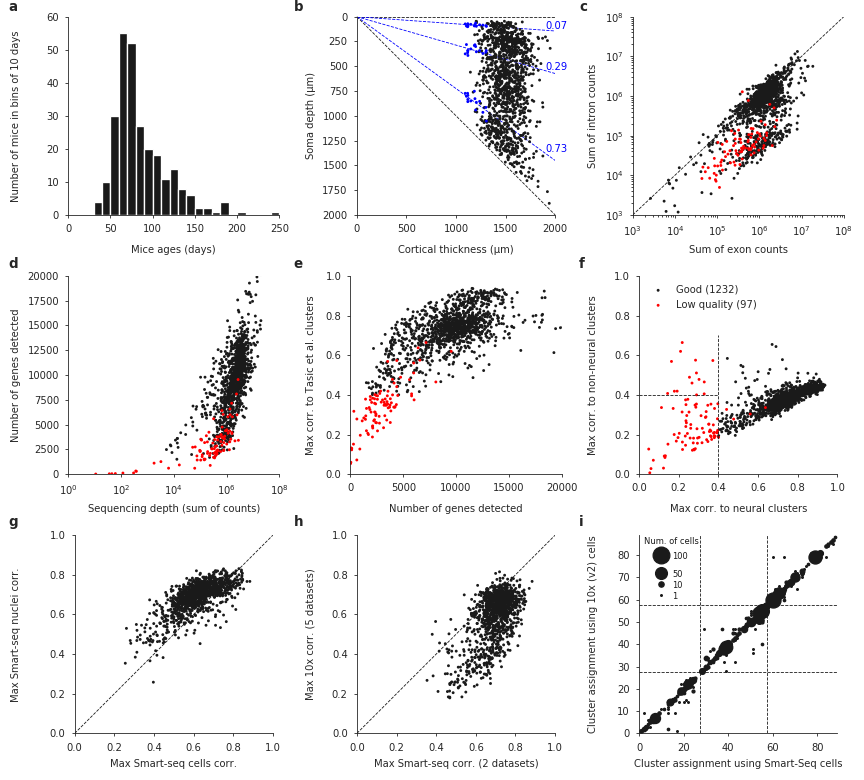

In [10]:
tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))

n = m1.cells.size
highestcorrs = np.zeros((n, len(ttypes['m1corrs'])))                        
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i,dataset in enumerate(sorted(ttypes['m1corrs'].keys())):
        m = np.nanmax(ttypes['m1corrs'][dataset], axis=1)
        highestcorrs[:,i] = m                        
highestcorrs = highestcorrs[~np.isnan(highestcorrs[:,0]),:]

########

fig = plt.figure(figsize=(7.2, 6.5))
dotsize=3

plt.subplot(331)
plt.hist(list(m1.mice_ages.values()), bins=np.arange(0,251,10), color='k')
plt.xlim([0,250])
plt.ylim([0,60])
plt.xlabel('Mice ages (days)')
plt.ylabel('Number of mice in bins of 10 days')

plt.subplot(332, aspect=1)
plt.scatter(m1.thickness, m1.depth, s=dotsize, color='k', edgecolors='none')
plt.xlim([0,2000])
plt.ylim([0,2000])
for b in [0,1]:
    plt.plot([0,2000],np.array([0,2000])*b,'k--',linewidth=.5, zorder=0, clip_on=False)
plt.xlabel('Cortical thickness (μm)')
plt.ylabel('Soma depth (μm)')
plt.gca().invert_yaxis()

nissl = pd.read_csv('../data/m1_nissl_layer_boundaries.csv',sep='\t')
plt.scatter(nissl['L6/total'], nissl['L1'], s=dotsize, color='blue', edgecolors='none')
plt.scatter(nissl['L6/total'], nissl['L2/3'], s=dotsize, color='blue', edgecolors='none')
plt.scatter(nissl['L6/total'], nissl['L5'], s=dotsize, color='blue', edgecolors='none')
b1 = np.mean(nissl['L1']/nissl['L6/total'])
b2 = np.mean(nissl['L2/3']/nissl['L6/total'])
b3 = np.mean(nissl['L5']/nissl['L6/total'])
for b in [b1, b2, b3]:
    plt.plot([0,2000],np.array([0,2000])*b,'--',linewidth=.5, color='blue', zorder=0)
    plt.text(1900,1900*b-10, '{:.2f}'.format(b), fontsize=6, color='blue')

plt.subplot(333)
x = np.array(np.sum(m1.exonCounts,axis=1)).flatten()
y = np.array(np.sum(m1.intronCounts,axis=1)).flatten()
plt.scatter(x[ttypes['qc']=='good'], y[ttypes['qc']=='good'], s=dotsize, color='k', edgecolors='none')
plt.scatter(x[ttypes['qc']!='good'], y[ttypes['qc']!='good'], s=dotsize, color='red', edgecolors='none')
plt.xlim([1e+3,1e+8])
plt.ylim([1e+3,1e+8])
plt.plot([1e+3,1e+8], [1e+3,1e+8], 'k--', linewidth=.5, zorder=0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sum of exon counts')
plt.ylabel('Sum of intron counts')

plt.subplot(334)
x = np.array(np.sum(m1.exonCounts+m1.intronCounts, axis=1))
y = np.array(np.sum(m1.exonCounts+m1.intronCounts>0, axis=1))
plt.scatter(x[ttypes['qc']=='good'], y[ttypes['qc']=='good'], s=dotsize, color='k', edgecolors='none')
plt.scatter(x[ttypes['qc']!='good'], y[ttypes['qc']!='good'], s=dotsize, color='red', edgecolors='none')
plt.xlabel('Sequencing depth (sum of counts)')
plt.ylabel('Number of genes detected')
plt.ylim([0,20000])
plt.xlim([1, 10**8])
plt.xscale('log')

plt.subplot(335)
x = np.array(np.sum(m1.exonCounts+m1.intronCounts>0, axis=1))
y = np.amax(ttypes['tasicCorrs'], axis=1)
plt.scatter(x[ttypes['qc']=='good'], y[ttypes['qc']=='good'], s=dotsize, color='k', edgecolors='none')
plt.scatter(x[ttypes['qc']!='good'], y[ttypes['qc']!='good'], s=dotsize, color='red', edgecolors='none')
plt.ylim([0,1])
plt.xlim([0,20000])
plt.xlabel('Number of genes detected')
plt.ylabel('Max corr. to Tasic et al. clusters')

plt.subplot(336, aspect=1)
x = np.amax(ttypes['tasicCorrs'][:,:117], axis=1)
y = np.amax(ttypes['tasicCorrs'][:,117:], axis=1)
a = plt.scatter(x[ttypes['qc']=='good'], y[ttypes['qc']=='good'], s=dotsize, color='k', edgecolors='none')
b = plt.scatter(x[ttypes['qc']!='good'], y[ttypes['qc']!='good'], s=dotsize, color='red', edgecolors='none')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Max corr. to neural clusters')
plt.ylabel('Max corr. to non-neural clusters')
plt.plot([0,.4], [.4,.4], 'k--', linewidth=.5)
plt.plot([.4,.4], [0, .7], 'k--', linewidth=.5)
plt.legend([a,b],['Good (' + str(np.sum(ttypes['qc']=='good')) + ')', 
            'Low quality (' + str(np.sum(ttypes['qc']!='good')) + ')'], 
           frameon=False, loc='upper left')

plt.subplot(337, aspect=1)
plt.plot([0,1], [0,1], 'k--', linewidth=.5)
plt.scatter(highestcorrs[:,5], highestcorrs[:,6], s=dotsize, color='k', edgecolors='none')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Max Smart-seq cells corr.')
plt.ylabel('Max Smart-seq nuclei corr.')

plt.subplot(338, aspect=1)
plt.plot([0,1], [0,1], 'k--', linewidth=.5)
plt.scatter(np.max(highestcorrs[:,5:], axis=1), np.max(highestcorrs[:,:5], axis=1),
            s=dotsize, color='k', edgecolors='none')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Max Smart-seq corr. (2 datasets)')
plt.ylabel('Max 10x corr. (5 datasets)')

plt.subplot(339, aspect=1)
for i in range(clusterN):
    for j in range(clusterN):
        n = np.sum((ttypes['m1ass']['SmartSeq_cells_AIBS']==i) &
                   (ttypes['m1ass']['10X_cells_v2_AIBS']==j))
        if n>0:
            plt.scatter(i+1,j+1,s=n,color='k')
for b in np.where(np.isin(clusterNames, ['Sst Chodl', 'L2/3 IT_1']))[0]:
    plt.plot([0,clusterN+1],[b+.5,b+.5], 'k--', linewidth=0.5, zorder=0)
    plt.plot([b+.5,b+.5],[0,clusterN+1], 'k--', linewidth=0.5, zorder=0) 
plt.xlim([0,clusterN+1])
plt.ylim([0,clusterN+1])
plt.xlabel('Cluster assignment using Smart-Seq cells')
plt.ylabel('Cluster assignment using 10x (v2) cells')

plt.scatter(10,80,s=100,color='k')
plt.scatter(10,72,s=50,color='k')
plt.scatter(10,67,s=10,color='k')
plt.scatter(10,62,s=1,color='k')
plt.text(2,85,'Num. of cells', color='k', fontsize=5, )
plt.text(15, 80-.5, '100', color='k', fontsize=5, va='center')
plt.text(15, 72-.5, '50',  color='k', fontsize=5, va='center')
plt.text(15, 67-.5, '10',  color='k', fontsize=5, va='center')
plt.text(15, 62-.5, '1',   color='k', fontsize=5, va='center')

abc = 'abcdefghi'
for i,a in enumerate(abc):
    fig.text(.01 + (i%3)*.33, 1-np.floor(i/3)*.33, a, fontsize=8, fontweight='bold', va='top')

plt.gcf().align_labels()
sns.despine()
plt.tight_layout()

plt.savefig('../figures/suppfigures/qc.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/qc.pdf', dpi=300)

<IPython.core.display.Javascript object>


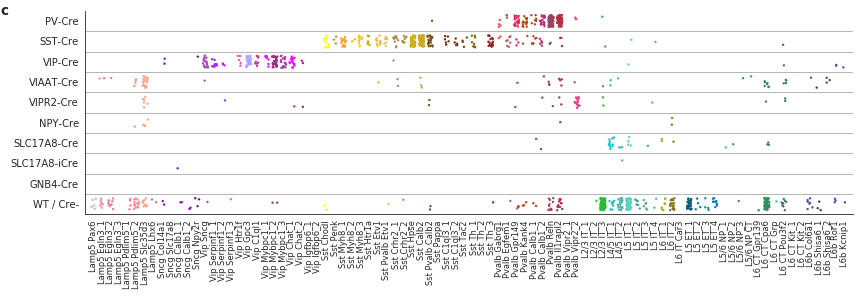

1227 cells plotted


In [11]:
fig = plt.figure(figsize=(7.2, 2.5))

creminus = ['PV-', 'SCNN1', 'SST-', 'VIAAT-', 'VIP-', 'VIPR2-', 'NPY-', 
            'SLC17a8-', 'SLC17a8-iCre-', 'GNB4-', 'WT']
count = 0
np.random.seed(42)
for t in range(clusterN):
    for crenum, cre in enumerate([['PV+'], ['SST+'], ['VIP+'], ['VIAAT+'], 
                                  ['VIPR2+'], ['NPY+'], ['SLC17a8+'], 
                                  ['SLC17a8-iCre+'], ['GNB4+'], creminus]):
        n = np.sum(np.isin(m1.cre, cre) & (ttypes['m1consensus_ass']==t) & (m1.exclude==''))
        count += n
        
        plt.scatter(t      + np.random.uniform(-.3,.3, size=n),
                    crenum + np.random.uniform(-.3,.3, size=n), 
                    c=clusterColors[t], s=2, edgecolor='none')
        
plt.xticks(range(clusterN), clusterNames, rotation=90, fontsize=5)
plt.xlim([-1, clusterN])
yt = ['PV-Cre', 'SST-Cre', 'VIP-Cre', 'VIAAT-Cre', 'VIPR2-Cre', 'NPY-Cre', 
      'SLC17A8-Cre', 'SLC17A8-iCre', 'GNB4-Cre', 'WT / Cre-']
plt.ylim([-.5, len(yt) - .5])
plt.yticks(np.arange(len(yt)), yt)
plt.gca().tick_params(length=0)
plt.gca().invert_yaxis()

for b in range(len(yt)-1):
    plt.plot([-1, clusterN], [b+.5,b+.5], color='#aaaaaa', linewidth=.5)
        
sns.despine()
plt.tight_layout()

# Part of a composite suppl figure, hence panel C
fig.text(0, .95, 'c', fontsize=8, fontweight='bold')

plt.savefig('../figures/suppfigures/crelines.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/crelines.pdf', dpi=300)

print('{} cells plotted'.format(count))

## Mapping diagnostics for all cells

<IPython.core.display.Javascript object>


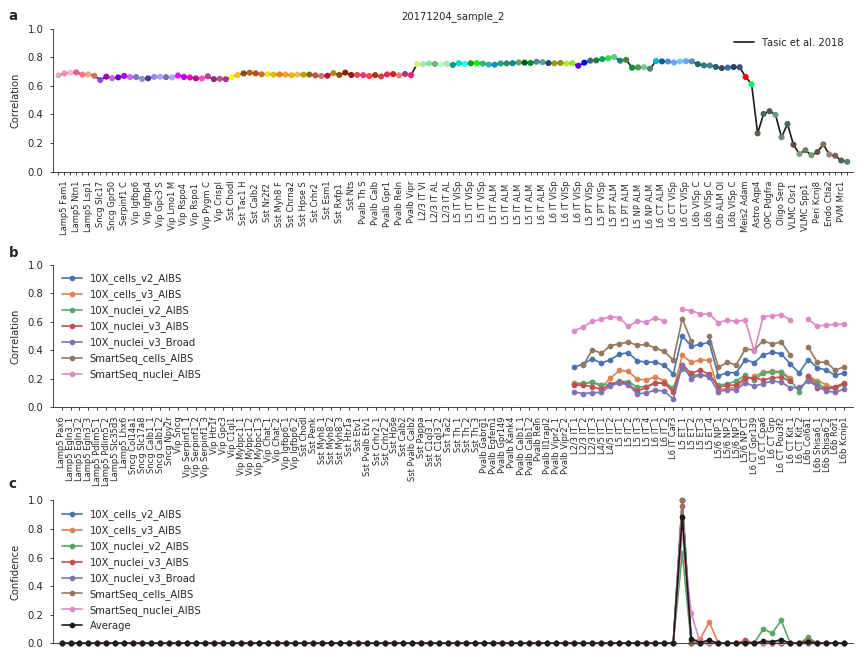

In [12]:
neuron = 0

tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))

fig = plt.figure(figsize=(7.2,5.5))
plt.subplot(311)
h1 = plt.plot(ttypes['tasicCorrs'][neuron,:], 'k', linewidth=1, clip_on=False, zorder=0)
h11 = plt.scatter(np.arange(tasic2018['clusterNames'].size), ttypes['tasicCorrs'][neuron,:], s=8, 
                  color=tasic2018['clusterColors'])
plt.xlim([-1,tasic2018['clusterNames'].size])
plt.ylim([0,1])
plt.xticks(np.arange(tasic2018['clusterNames'].size), 
           [c[:10] if i%2 else '' for i,c in enumerate(tasic2018['clusterNames'])], 
           rotation=90, fontsize=5)
ht = plt.title(m1.cells[neuron])
plt.legend(['Tasic et al. 2018'], frameon=False)
plt.ylabel('Correlation')

plt.subplot(312)
h2 = []
for dataset in sorted(ttypes['m1corrs'].keys()):
    h = plt.plot(ttypes['m1corrs'][dataset][neuron,:], '.-', linewidth=1, clip_on=False)
    h2.append(h)
plt.xlim([-1, clusterN])
plt.ylim([0,1])
plt.xticks(np.arange(clusterN), clusterNames, rotation=90, fontsize=5)
plt.legend(sorted(ttypes['m1corrs'].keys()), frameon=False)
plt.ylabel('Correlation')

plt.subplot(313)
h3 = []
for dataset in sorted(ttypes['m1boot'].keys()):
    h = plt.plot(ttypes['m1boot'][dataset][neuron,:], '.-', linewidth=1, clip_on=False)
    h3.append(h)
h = plt.plot(ttypes['m1consensus_boot'][neuron,:], 'k.-', linewidth=1, clip_on=False)
h3.append(h)
plt.xlim([-1, clusterN])
plt.ylim([0,1])
plt.xticks([])
plt.legend(sorted(ttypes['m1boot'].keys())+['Average'], frameon=False)
plt.ylabel('Confidence')

fig.text(.01, .97, 'a', fontsize=8, fontweight='bold')
fig.text(.01, .61, 'b', fontsize=8, fontweight='bold')
fig.text(.01, .26, 'c', fontsize=8, fontweight='bold')

sns.despine()
plt.tight_layout()

plt.savefig('../figures/suppfigures/ttype-assignment.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/ttype-assignment.pdf', dpi=300)

In [5]:
%%time

for neuron in range(m1.cells.size):
    if neuron%10 == 0:
        print('.', end='')
    h1[0].set_ydata(ttypes['tasicCorrs'][neuron,:])
    newpos = np.concatenate((np.arange(tasic2018['clusterNames'].size)[:,np.newaxis], 
                             ttypes['tasicCorrs'][neuron,:][:,np.newaxis]), axis=1)
    h11.set_offsets(newpos)
    for i,dataset in enumerate(sorted(ttypes['m1corrs'].keys())):
        h2[i][0].set_ydata(ttypes['m1corrs'][dataset][neuron,:])
    mu = np.zeros(clusterN)
    for i,dataset in enumerate(sorted(ttypes['m1corrs'].keys())):
        h3[i][0].set_ydata(ttypes['m1boot'][dataset][neuron,:])
        mu += ttypes['m1boot'][dataset][neuron,:].squeeze()
    h3[-1][0].set_ydata(mu/7)
    ht.set_text(m1.cells[neuron])
    plt.savefig('../figures/sanity-checks/ttype-assignment/{:04}_{}.png'.format(neuron+1, m1.cells[neuron]), dpi=150)
print(' done')

..................................................................................................................................... done
CPU times: user 8min 58s, sys: 20.3 s, total: 9min 18s
Wall time: 9min 18s


## Non-neural contamination

<IPython.core.display.Javascript object>


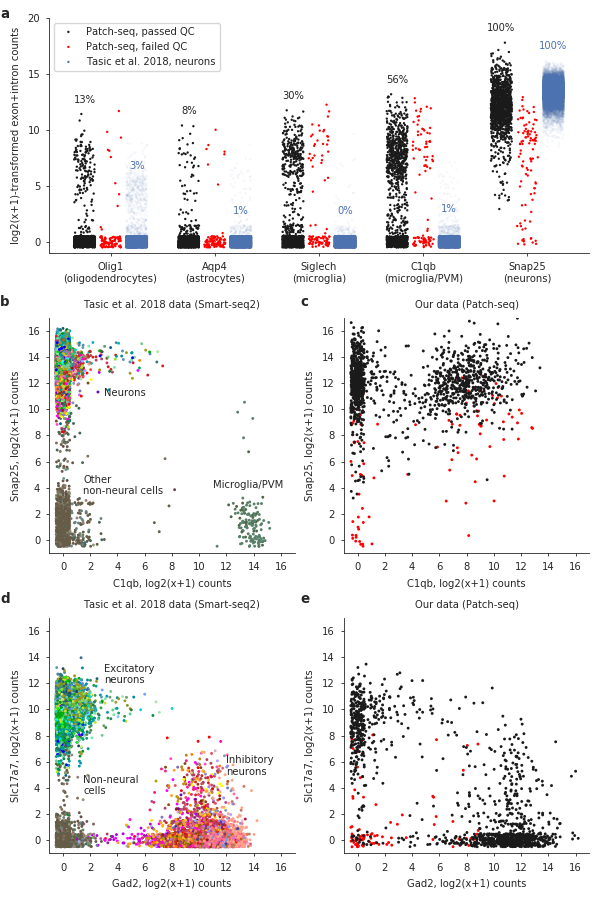

0.0592272382904764


In [3]:
fig = plt.figure(figsize=(5,7.5))

genes = ['Olig1', 'Aqp4', 'Siglech', 'C1qb', 'Snap25']
genesExplanations = ['oligodendrocytes', 'astrocytes', 'microglia', 'microglia/PVM', 'neurons']
counts = m1.exonCounts + m1.intronCounts

tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))
tasicCounts = tasic2018['counts'] + tasic2018['intronCounts']
tasicGenes  = tasic2018['genes']

dotsize = 2
plt.subplot(311)

for i,g in enumerate(genes):
    c = counts[:, m1.genes==g].toarray().flatten()
    
    cc = np.log2(1+c)
    cc += np.random.rand(c.size) -.5
    
    ind = ttypes['qc']=='good'
    s1 = plt.scatter(i + np.random.rand(np.sum(ind))/5, cc[ind], s=dotsize, color='k', edgecolors='none')
    plt.text(i + .1, max(cc[ind])+1, '{:.0f}%'.format(np.mean(c[ind]>0)*100), fontsize=6, ha='center')
    
    ind = ttypes['qc']!='good'
    s2 = plt.scatter(i + .25 + np.random.rand(np.sum(ind))/5, cc[ind], s=dotsize, color='red', edgecolors='none')
    
    c = tasicCounts[:, tasicGenes==g][tasic2018['clusters']<117,:].toarray().flatten()
    cc = np.log2(1+c)
    cc += np.random.rand(c.size) -.5
    plt.scatter(i + .5 + np.random.rand(c.size)/5, cc, s=dotsize, color='b', edgecolors='none', 
                alpha = m1.exonCounts.shape[0]/cc.size, rasterized=True)
    plt.text(i + .6, np.percentile(cc, 99)+2, 
             '{:.0f}%'.format(np.mean(c>0)*100), fontsize=6, ha='center', color='b')

s3 = plt.scatter(.5, 0, s=dotsize, color='b', edgecolors='none')
    
sns.despine()
plt.ylabel('log2(x+1)-transformed exon+intron counts')
plt.ylim([-1,20])
plt.yticks([0,5,10,15,20])

plt.xticks(.35 + np.arange(len(genes)), 
           [genes[i] + '\n(' + genesExplanations[i] + ')' for i in range(len(genes))])

plt.legend([s1,s2,s3], ['Patch-seq, passed QC', 
                        'Patch-seq, failed QC', 
                        'Tasic et al. 2018, neurons'])

print(m1.exonCounts.shape[0]/cc.size)

In [4]:
counts = m1.exonCounts + m1.intronCounts

tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))
tasicCounts = tasic2018['counts'] + tasic2018['intronCounts']
tasicGenes  = tasic2018['genes']

c = tasicCounts[:, tasicGenes=='C1qb'].toarray().flatten()
c = np.log2(1+c)
c += np.random.rand(c.size) -.5

b = tasicCounts[:, tasicGenes=='Snap25'].toarray().flatten()
b = np.log2(1+b)
b += np.random.rand(b.size) -.5

plt.subplot(323)
s0 = plt.scatter(c, b, s=3, color=tasic2018['clusterColors'][tasic2018['clusters']], edgecolors='none')
plt.ylabel('Snap25, log2(x+1) counts')
plt.xlabel('C1qb, log2(x+1) counts')
plt.xlim([-1,17])
plt.ylim([-1,17])
plt.xticks(np.arange(0,17,2))
plt.title('Tasic et al. 2018 data (Smart-seq2)')

c = counts[:, m1.genes=='C1qb'].toarray().flatten()
c = np.log2(1+c)
c += np.random.rand(c.size) -.5

b = counts[:, m1.genes=='Snap25'].toarray().flatten()
b = np.log2(1+b)
b += np.random.rand(b.size) -.5

plt.text(3,11,'Neurons')
plt.text(11,4,'Microglia/PVM')
plt.text(1.5,3.5,'Other\nnon-neural cells')

plt.subplot(324)
ind = ttypes['qc']!='good'
s1 = plt.scatter(c[ind], b[ind], s=3, color='red', edgecolors='none')
ind = ttypes['qc']=='good'
s2 = plt.scatter(c[ind], b[ind], s=3, color='k', edgecolors='none')

plt.ylabel('Snap25, log2(x+1) counts')
plt.xlabel('C1qb, log2(x+1) counts')
plt.xlim([-1,17])
plt.ylim([-1,17])
plt.xticks(np.arange(0,17,2))
plt.title('Our data (Patch-seq)');

In [5]:
counts = m1.exonCounts + m1.intronCounts

tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))
tasicCounts = tasic2018['counts'] + tasic2018['intronCounts']
tasicGenes  = tasic2018['genes']

c = tasicCounts[:, tasicGenes=='Gad2'].toarray().flatten()
c = np.log2(1+c)
c += np.random.rand(c.size) -.5

b = tasicCounts[:, tasicGenes=='Slc17a7'].toarray().flatten()
b = np.log2(1+b)
b += np.random.rand(b.size) -.5

plt.subplot(325)
s0 = plt.scatter(c, b, s=3, color=tasic2018['clusterColors'][tasic2018['clusters']], edgecolors='none')
plt.xlabel('Gad2, log2(x+1) counts')
plt.ylabel('Slc17a7, log2(x+1) counts')
plt.xlim([-1,17])
plt.ylim([-1,17])
plt.xticks(np.arange(0,17,2))
plt.title('Tasic et al. 2018 data (Smart-seq2)')

c = counts[:, m1.genes=='Gad1'].toarray().flatten()
c = np.log2(1+c)
c += np.random.rand(c.size) -.5

b = counts[:, m1.genes=='Slc17a7'].toarray().flatten()
b = np.log2(1+b)
b += np.random.rand(b.size) -.5

plt.text(3,12,'Excitatory\nneurons')
plt.text(12,5,'Inhibitory\nneurons')
plt.text(1.5,3.5,'Non-neural\ncells')

plt.subplot(326)
ind = ttypes['qc']!='good'
s1 = plt.scatter(c[ind], b[ind], s=3, color='red', edgecolors='none')
ind = ttypes['qc']=='good'
s2 = plt.scatter(c[ind], b[ind], s=3, color='k', edgecolors='none')

plt.xlabel('Gad2, log2(x+1) counts')
plt.ylabel('Slc17a7, log2(x+1) counts')
plt.xlim([-1,17])
plt.ylim([-1,17])
plt.xticks(np.arange(0,17,2))
plt.title('Our data (Patch-seq)')

sns.despine()
plt.tight_layout()

fig.text(0,.98, 'a', fontweight='bold', fontsize=8)
fig.text(0,.66, 'b', fontweight='bold', fontsize=8)
fig.text(.5,.66, 'c', fontweight='bold', fontsize=8)
fig.text(0,.33, 'd', fontweight='bold', fontsize=8)
fig.text(.5,.33, 'e', fontweight='bold', fontsize=8)

plt.savefig('../figures/suppfigures/contamination-markers.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/contamination-markers.pdf', dpi=300)